In [1]:
import sys
from os import path
import os

import numpy as np
import matplotlib as mpl
#mpl.use('pgf')
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import meet
import helper_scripts.helper_functions as helper_functions
import tables

####################################
# apply some settings for plotting #
####################################
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['axes.titlesize'] = 10

cmap = 'plasma'
color1 = '#e66101'.upper()
color2 = '#5e3c99'.upper()

meg_srate = 20000
eeg_srate = 10000

#pgf_with_latex = {
#    "pgf.texsystem": "xelatex",     # Use xetex for processing
#    "text.usetex": True,            # use LaTeX to write all text
#    "pgf.preamble": [
#        r'\usepackage{xcolor}',     # xcolor for colours
#        r'\usepackage[super]{nth}', # nth for counts
#        r'\usepackage{textgreek}',
#        r'\thickmuskip=1mu', # for smaller spacing
#        r'\medmuskip=1mu', # for smaller spacing
#    ]
#}
#mpl.rcParams.update(pgf_with_latex)

blind_ax = dict(top=False, bottom=False, left=False, right=False,
        labelleft=False, labelright=False, labeltop=False, labelbottom=False)

subject = 'S1'

data_folder = '../Data'
results_main_folder = '../Results'
results_folder_meg = path.join(results_main_folder, subject+'_MEG_only')
results_folder_meeg = path.join(results_main_folder, subject+'_MEEG_comb')

if not path.exists(subject):
    os.mkdir(subject)

EEG_ref = 'Fp2'
channames = list(np.loadtxt('EEG_channels.txt', dtype='str'))
coords = meet.sphere.getStandardCoordinates(channames + [EEG_ref])


meg_stim_file = '%s_MEG_only_stim.dat' % subject
Meeg_stim_file = '%s_MEG_comb_stim.dat' % subject
mEeg_stim_file = '%s_EEG_comb_stim.hdf5' % subject

meg_stim_data = helper_functions.readMEG(
        path.join(path.join(data_folder, subject), meg_stim_file),
        s_rate=meg_srate, num_chans=2)
Meeg_stim_data = helper_functions.readMEG(
        path.join(path.join(data_folder, subject), Meeg_stim_file),
        s_rate=meg_srate, num_chans=2)

meg_stim_file = '%s_MEG_only_stim.dat' % subject
Meeg_stim_file = '%s_MEG_comb_stim.dat' % subject
mEeg_stim_file = '%s_EEG_comb_stim.hdf5' % subject

meg_stim_data = helper_functions.readMEG(
        path.join(path.join(data_folder, subject), meg_stim_file),
        s_rate=meg_srate, num_chans=2)
Meeg_stim_data = helper_functions.readMEG(
        path.join(path.join(data_folder, subject), Meeg_stim_file),
        s_rate=meg_srate, num_chans=2)

with tables.open_file(path.join(path.join(data_folder, subject),
    mEeg_stim_file), 'r') as f:
    mEeg_stim_data = f.root.EEG_data[:,:]

# get the stimuli
meg_marker = meet.getMarker(meg_stim_data[-1])
Meeg_marker = meet.getMarker(Meeg_stim_data[-1])
mEeg_marker = meet.getMarker(mEeg_stim_data[-1]) + 39

'''
meg_stim_file = path.join(results_folder_meg, '%s_MEG_only_cleaned_data.npy' % subject)
Meeg_stim_file = path.join(results_folder_meeg, '%s_meg_cleaned_data.npy' % subject)
mEeg_stim_file = path.join(results_folder_meeg, '%s_eeg_cleaned_data.npy' % subject)

meg_stim_data = np.load(meg_stim_file)
Meeg_stim_data = np.load(Meeg_stim_file)
mEeg_stim_data = np.load(mEeg_stim_file)

# get the stimuli
meg_marker = meet.getMarker(meg_stim_data[-1])
Meeg_marker = meet.getMarker(Meeg_stim_data[-1])
mEeg_marker = meet.getMarker(mEeg_stim_data[-1])
'''

# remove the marker channel
meg_stim_data = meg_stim_data[0]
Meeg_stim_data = Meeg_stim_data[0]
mEeg_stim_data = mEeg_stim_data[:len(channames)]

# interpolate the stimulus
meg_interpolate_win = [-30,30]
eeg_interpolate_win = [-30,30]

meg_stim_data = meet.interpolateEEG(meg_stim_data, meg_marker,
        meg_interpolate_win)
Meeg_stim_data = meet.interpolateEEG(Meeg_stim_data, Meeg_marker,
        meg_interpolate_win)
mEeg_stim_data = meet.interpolateEEG(mEeg_stim_data, mEeg_marker,
        eeg_interpolate_win)

# prepare calculation of SNR
SNR_win_ms = [10, 55]
meg_SNR_win = np.round(np.array(SNR_win_ms)/1000.*meg_srate
        ).astype(int)
meg_SNR_t = (np.arange(meg_SNR_win[0], meg_SNR_win[1], 1)/
        float(meg_srate)*1000)
eeg_SNR_win = np.round(np.array(SNR_win_ms)/1000.*eeg_srate
        ).astype(int)
eeg_SNR_t = (np.arange(eeg_SNR_win[0], eeg_SNR_win[1], 1)/
        float(eeg_srate)*1000)

meg_bootstrap_marker_idx = helper_functions.getBootstrapMarkerIdx(
        meg_stim_data, meg_marker, win=meg_SNR_win,
        clip_points=int(2*meg_srate))

Meeg_bootstrap_marker_idx = helper_functions.getBootstrapMarkerIdx(
        Meeg_stim_data, Meeg_marker, win=meg_SNR_win,
        clip_points=int(2*meg_srate))

mEeg_bootstrap_marker_idx = helper_functions.getBootstrapMarkerIdx(
        mEeg_stim_data[0], mEeg_marker, win=eeg_SNR_win,
        clip_points=int(2*eeg_srate))

# apply a 0.5 Hz high-pass filter
meg_stim_data_hp = meet.stim_data = meet.iir.butterworth(meg_stim_data, fs=0.1,
        fp=0.5, s_rate=meg_srate)
Meeg_stim_data_hp = meet.stim_data = meet.iir.butterworth(Meeg_stim_data, fs=0.1,
        fp=0.5, s_rate=meg_srate)
mEeg_stim_data_hp = meet.stim_data = meet.iir.butterworth(mEeg_stim_data, fs=0.1,
        fp=0.5, s_rate=eeg_srate)

# apply 450Hz-750 Hz band-pass filter
meg_stim_data_sigma = meet.stim_data = meet.iir.butterworth(meg_stim_data,
        fs=(400,800), fp=(450,750), s_rate=meg_srate)
Meeg_stim_data_sigma = meet.stim_data = meet.iir.butterworth(Meeg_stim_data,
        fs=(400,800), fp=(450,750), s_rate=meg_srate)
mEeg_stim_data_sigma = meet.stim_data = meet.iir.butterworth(mEeg_stim_data,
        fs=(400,800), fp=(450,750), s_rate=eeg_srate)


##################
# get the trials #
##################
trial_win_ms = [-60,160]
meg_trial_win = np.round(np.array(trial_win_ms)/1000.*meg_srate
        ).astype(int)
meg_trial_t = (np.arange(meg_trial_win[0], meg_trial_win[1], 1)/
        float(meg_srate)*1000)
eeg_trial_win = np.round(np.array(trial_win_ms)/1000.*eeg_srate
        ).astype(int)
eeg_trial_t = (np.arange(eeg_trial_win[0], eeg_trial_win[1], 1)/
        float(eeg_srate)*1000)

# for high-pass
meg_trials_hp = meet.epochEEG(meg_stim_data_hp, meg_marker, meg_trial_win)
Meeg_trials_hp = meet.epochEEG(Meeg_stim_data_hp, Meeg_marker, meg_trial_win)

mEeg_trials_hp = meet.epochEEG(mEeg_stim_data_hp[np.array(channames)=='CP6'] - 
        mEeg_stim_data_hp[np.array(channames)=='Fz'], mEeg_marker,
        eeg_trial_win)[0]


# for sigma
meg_trials_sigma = meet.epochEEG(meg_stim_data_sigma, meg_marker,
        meg_trial_win)
Meeg_trials_sigma = meet.epochEEG(Meeg_stim_data_sigma, Meeg_marker,
        meg_trial_win)

mEeg_trials_sigma = meet.epochEEG(
        mEeg_stim_data_sigma[np.array(channames)=='CP6'] - 
        mEeg_stim_data_sigma[np.array(channames)=='Fz'], mEeg_marker,
        eeg_trial_win)[0]



#################
# calculate SNR #
#################
# for meg
meg_SNNR_sigma = helper_functions.bootstrap_SNR(
        meg_stim_data_sigma, meg_marker, meg_SNR_win,
        meg_bootstrap_marker_idx)

# for Meeg
Meeg_SNNR_sigma = helper_functions.bootstrap_SNR(
        Meeg_stim_data_sigma, Meeg_marker, meg_SNR_win,
        Meeg_bootstrap_marker_idx)

# for mEeg
mEeg_SNNR_sigma = helper_functions.bootstrap_SNR(
        (mEeg_stim_data_sigma[np.array(channames)=='CP6'] -
            mEeg_stim_data_sigma[np.array(channames)=='Fz'])[0],
        mEeg_marker, eeg_SNR_win, mEeg_bootstrap_marker_idx)


# calculate bCSTP for EEG data
# for sigma
(sigma_mEeg_sfilter, sigma_mEeg_tfilter, sigma_mEeg_seigvals,
        sigma_mEeg_teigvals) = meet.spatfilt.bCSTP(
                meet.epochEEG(mEeg_stim_data_sigma, mEeg_marker,
                    eeg_SNR_win),
                meet.epochEEG(mEeg_stim_data_sigma,
                    np.random.choice(mEeg_bootstrap_marker_idx,
                        size=10000,
                        replace=False), eeg_SNR_win),
                    s_keep=1, t_keep=1, num_iter=30)


# get spatial patterns
sigma_mEeg_spattern = np.hstack([np.linalg.inv(sigma_mEeg_sfilter[-1]),
    np.zeros([sigma_mEeg_sfilter[-1].shape[-1], 1])])

#normalize spatial patterns
sigma_mEeg_spattern /= np.abs(sigma_mEeg_spattern).max(-1)[...,np.newaxis]

# interpolate the maps
sigma_mEeg_potMap = meet.sphere.potMap(coords, sigma_mEeg_spattern[0])

mEeg_sfilter_data_sigma = np.dot(sigma_mEeg_sfilter[-1][:,0],
        mEeg_stim_data_sigma)

# calculate the spatially filtered trials
mEeg_sfilter_trials_sigma = meet.epochEEG(mEeg_sfilter_data_sigma,
        mEeg_marker, eeg_trial_win)

# re-calculate SNR
mEeg_SNNR_sfilter_sigma = helper_functions.bootstrap_SNR(
        mEeg_sfilter_data_sigma, mEeg_marker, eeg_SNR_win,
        mEeg_bootstrap_marker_idx)


################################################
# calculate temporal filter for all recordings #
################################################
# for sigma
meg_sigma_temp_filter, meg_sigma_temp_eigvals = (
        helper_functions.get_temp_filter(
            meg_stim_data_sigma, meg_marker, meg_SNR_win,
            meg_bootstrap_marker_idx))
Meeg_sigma_temp_filter, Meeg_sigma_temp_eigvals = (
        helper_functions.get_temp_filter(
            Meeg_stim_data_sigma, Meeg_marker, meg_SNR_win,
            Meeg_bootstrap_marker_idx))
mEeg_sigma_temp_filter = sigma_mEeg_tfilter[-1]


###############################################
# convolve the data with the temporal filters #
###############################################
# for sigma
meg_tempfilt_data_sigma = np.convolve(meg_sigma_temp_filter[::-1,0],
        meg_stim_data_sigma, mode='same')
Meeg_tempfilt_data_sigma = np.convolve(Meeg_sigma_temp_filter[::-1,0],
        Meeg_stim_data_sigma, mode='same')
mEeg_tempfilt_data_sigma = np.convolve(mEeg_sigma_temp_filter[::-1,0],
        mEeg_sfilter_data_sigma, mode='same')

# re-calculate SNR
# for sigma
meg_SNNR_tempfilt_sigma = helper_functions.bootstrap_SNR(
        meg_tempfilt_data_sigma, meg_marker, meg_SNR_win,
        meg_bootstrap_marker_idx)
Meeg_SNNR_tempfilt_sigma = helper_functions.bootstrap_SNR(
        Meeg_tempfilt_data_sigma, Meeg_marker, meg_SNR_win,
        Meeg_bootstrap_marker_idx)
mEeg_SNNR_tempfilt_sigma = helper_functions.bootstrap_SNR(
        mEeg_tempfilt_data_sigma, mEeg_marker, eeg_SNR_win,
        mEeg_bootstrap_marker_idx)

# re-calculate trials
# for sigma
meg_tempfilt_trials_sigma = meet.epochEEG(meg_tempfilt_data_sigma,
        meg_marker, meg_trial_win)
Meeg_tempfilt_trials_sigma = meet.epochEEG(Meeg_tempfilt_data_sigma,
        Meeg_marker, meg_trial_win)
mEeg_tempfilt_trials_sigma = meet.epochEEG(mEeg_tempfilt_data_sigma,
        mEeg_marker, eeg_trial_win)

Iteration 1 of 30 total iterations.
Iteration 2 of 30 total iterations.
Iteration 3 of 30 total iterations.
Iteration 4 of 30 total iterations.
Iteration 5 of 30 total iterations.
Iteration 6 of 30 total iterations.
Iteration 7 of 30 total iterations.
Iteration 8 of 30 total iterations.
Iteration 9 of 30 total iterations.
Iteration 10 of 30 total iterations.
Iteration 11 of 30 total iterations.
Iteration 12 of 30 total iterations.
Iteration 13 of 30 total iterations.
Iteration 14 of 30 total iterations.
Iteration 15 of 30 total iterations.
Iteration 16 of 30 total iterations.
Iteration 17 of 30 total iterations.
Iteration 18 of 30 total iterations.
Iteration 19 of 30 total iterations.
Iteration 20 of 30 total iterations.
Iteration 21 of 30 total iterations.
Iteration 22 of 30 total iterations.
Iteration 23 of 30 total iterations.
Iteration 24 of 30 total iterations.
Iteration 25 of 30 total iterations.
Iteration 26 of 30 total iterations.
Iteration 27 of 30 total iterations.
Iteration 

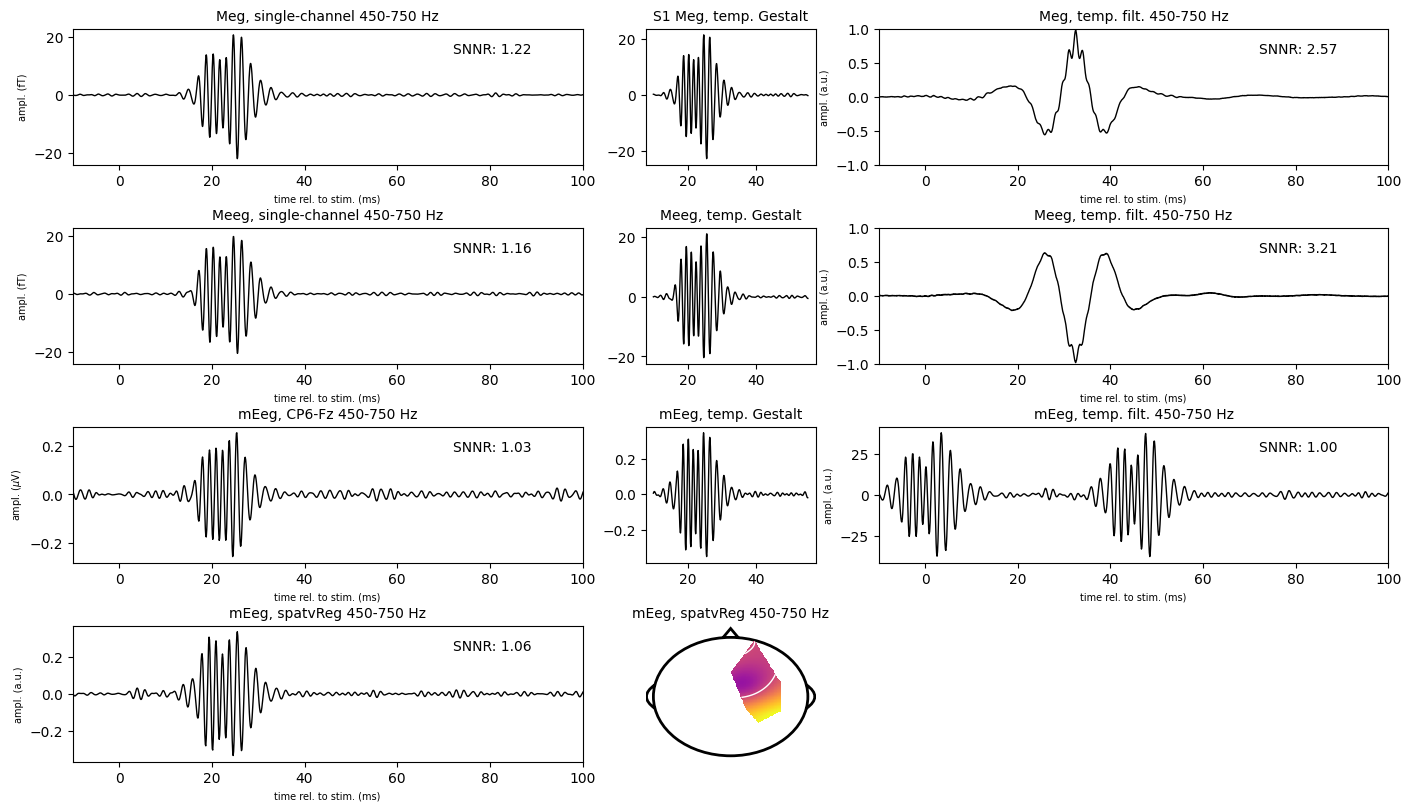

In [2]:
####################
# plot the results #
####################
fig = plt.figure(figsize=(14,8))
gs = mpl.gridspec.GridSpec(nrows=4, ncols=3, figure=fig,
        height_ratios = (10,10,10,10),
        width_ratios=(3,1,3))

# make axes for the titles
'''
title_ax1 = fig.add_subplot(gs[0,:], frame_on=False)
title_ax2 = fig.add_subplot(gs[2,:], frame_on=False)
title_ax3 = fig.add_subplot(gs[4,:], frame_on=False)
title_ax1.tick_params(**blind_ax)
title_ax2.tick_params(**blind_ax)
title_ax3.tick_params(**blind_ax)
'''
'''
title_ax1.text(0.5, 0.5, s=r'MEG only', ha='center', va='top',
        fontsize=10, transform=title_ax1.transAxes)
title_ax2.text(0.5, 0.5, s=r'MEEG: MEG data', ha='center',
        va='top', fontsize=10, transform=title_ax2.transAxes)
title_ax3.text(0.5, 0.5, s=r'MEEG: EEG data',
        ha='center', va='top',
        fontsize=10, transform=title_ax3.transAxes)
'''

# plot the single channels
sc_meg_sigma_ax = fig.add_subplot(gs[0,0])
sc_meg_sigma_ax.plot(meg_trial_t, meg_trials_sigma.mean(-1), c='k', lw=1)
sc_meg_sigma_ax.text(0.9, 0.9, s=r'SNNR: %.2f' % (
    scipy.stats.scoreatpercentile(meg_SNNR_sigma, 50)),
    transform=sc_meg_sigma_ax.transAxes, ha='right', va='top')
sc_meg_sigma_ax.set_xlabel('time rel. to stim. (ms)')
sc_meg_sigma_ax.set_ylabel(r'ampl. (fT)')
sc_meg_sigma_ax.set_title('Meg, single-channel 450-750 Hz')


sc_Meeg_sigma_ax = fig.add_subplot(gs[1,0], sharex=sc_meg_sigma_ax,
        sharey=sc_meg_sigma_ax)
sc_Meeg_sigma_ax.plot(meg_trial_t, Meeg_trials_sigma.mean(-1), c='k', lw=1)
sc_Meeg_sigma_ax.text(0.9, 0.9, s=r'SNNR: %.2f' % (
    scipy.stats.scoreatpercentile(Meeg_SNNR_sigma, 50)),
    transform=sc_Meeg_sigma_ax.transAxes, ha='right', va='top')
sc_Meeg_sigma_ax.set_xlabel('time rel. to stim. (ms)')
sc_Meeg_sigma_ax.set_ylabel(r'ampl. (fT)')
sc_Meeg_sigma_ax.set_title('Meeg, single-channel 450-750 Hz')


sc_mEeg_sigma_ax = fig.add_subplot(gs[2,0], sharex=sc_meg_sigma_ax)
sc_mEeg_sigma_ax.plot(eeg_trial_t, mEeg_trials_sigma.mean(-1), c='k', lw=1)
sc_mEeg_sigma_ax.text(0.9, 0.9, s=r'SNNR: %.2f' % (
    scipy.stats.scoreatpercentile(mEeg_SNNR_sigma, 50)),
    transform=sc_mEeg_sigma_ax.transAxes, ha='right', va='top')
sc_mEeg_sigma_ax.set_xlabel('time rel. to stim. (ms)')
sc_mEeg_sigma_ax.set_ylabel(r'ampl. ($\mu$V)')
sc_mEeg_sigma_ax.set_title('mEeg, CP6-Fz 450-750 Hz')


################
# plot the spat #
################
# plot the patterns


spat_mEeg_sigma_ax_pat = fig.add_subplot(gs[3,1], frame_on=False)
spat_mEeg_sigma_ax_pat.tick_params(**blind_ax)
meet.sphere.addHead(spat_mEeg_sigma_ax_pat)
spat_mEeg_sigma_ax_pat.pcolormesh(
        sigma_mEeg_potMap[0], sigma_mEeg_potMap[1],
        sigma_mEeg_potMap[2], vmin=-1, vmax=1, rasterized=True, cmap=cmap)
spat_mEeg_sigma_ax_pat.contour(
        sigma_mEeg_potMap[0], sigma_mEeg_potMap[1],
        sigma_mEeg_potMap[2], levels=[0], colors='w', linewidths=1)
spat_mEeg_sigma_ax_pat.set_xlim([-1.1, 1.1])
spat_mEeg_sigma_ax_pat.set_ylim([-1.1, 1.2])
spat_mEeg_sigma_ax_pat.set_title('mEeg, spatvReg 450-750 Hz')



spat_mEeg_sigma_ax = fig.add_subplot(gs[3,0], sharex=sc_meg_sigma_ax)
spat_mEeg_sigma_ax.plot(eeg_trial_t, mEeg_sfilter_trials_sigma.mean(-1), c='k', lw=1)
spat_mEeg_sigma_ax.text(0.9, 0.9, s=r'SNNR: %.2f' % (
    scipy.stats.scoreatpercentile(mEeg_SNNR_sfilter_sigma, 50)),
    transform=spat_mEeg_sigma_ax.transAxes, ha='right', va='top')
spat_mEeg_sigma_ax.set_xlabel('time rel. to stim. (ms)')
spat_mEeg_sigma_ax.set_ylabel(r'ampl. (a.u.)')
spat_mEeg_sigma_ax.set_title('mEeg, spatvReg 450-750 Hz')


# plot the temporally filtered channels
tempfilter_meg_sigma_ax = fig.add_subplot(gs[0,1])
tempfilter_meg_sigma_ax.plot(meg_SNR_t,
        np.linalg.pinv(meg_sigma_temp_filter)[0], c='k', lw=1)
tempfilter_meg_sigma_ax.set_title(subject+' Meg, temp. Gestalt')

tempfilter_Meeg_sigma_ax = fig.add_subplot(gs[1,1],
        sharex=tempfilter_meg_sigma_ax)
tempfilter_Meeg_sigma_ax.plot(meg_SNR_t,
        np.linalg.pinv(Meeg_sigma_temp_filter)[0], c='k', lw=1)
tempfilter_Meeg_sigma_ax.set_title('Meeg, temp. Gestalt')

tempfilter_mEeg_sigma_ax = fig.add_subplot(gs[2,1],
        sharex=tempfilter_meg_sigma_ax)
tempfilter_mEeg_sigma_ax.plot(eeg_SNR_t,
        np.linalg.pinv(mEeg_sigma_temp_filter)[0], c='k', lw=1)
tempfilter_mEeg_sigma_ax.set_title('mEeg, temp. Gestalt')


tempfilt_meg_sigma_ax = fig.add_subplot(gs[0,2], sharex=sc_meg_sigma_ax)
tempfilt_meg_sigma_ax.plot(meg_trial_t, meg_tempfilt_trials_sigma.mean(-1), c='k', lw=1)
tempfilt_meg_sigma_ax.text(0.9, 0.9, s=r'SNNR: %.2f' % (
    scipy.stats.scoreatpercentile(meg_SNNR_tempfilt_sigma, 50)),
    transform=tempfilt_meg_sigma_ax.transAxes, ha='right', va='top')
tempfilt_meg_sigma_ax.set_xlabel('time rel. to stim. (ms)')
tempfilt_meg_sigma_ax.set_ylabel(r'ampl. (a.u.)')
tempfilt_meg_sigma_ax.set_title('Meg, temp. filt. 450-750 Hz')
tempfilt_meg_sigma_ax.set_ylim([-1,1])

tempfilt_Meeg_sigma_ax = fig.add_subplot(gs[1,2], sharex=sc_meg_sigma_ax)
tempfilt_Meeg_sigma_ax.plot(meg_trial_t, Meeg_tempfilt_trials_sigma.mean(-1), c='k', lw=1)
tempfilt_Meeg_sigma_ax.text(0.9, 0.9, s=r'SNNR: %.2f' % (
    scipy.stats.scoreatpercentile(Meeg_SNNR_tempfilt_sigma, 50)),
    transform=tempfilt_Meeg_sigma_ax.transAxes, ha='right', va='top')
tempfilt_Meeg_sigma_ax.set_xlabel('time rel. to stim. (ms)')
tempfilt_Meeg_sigma_ax.set_ylabel(r'ampl. (a.u.)')
tempfilt_Meeg_sigma_ax.set_title('Meeg, temp. filt. 450-750 Hz')
tempfilt_Meeg_sigma_ax.set_ylim([-1,1])


tempfilt_mEeg_sigma_ax = fig.add_subplot(gs[2,2], sharex=sc_meg_sigma_ax)
tempfilt_mEeg_sigma_ax.plot(eeg_trial_t, mEeg_tempfilt_trials_sigma.mean(-1), c='k', lw=1)
tempfilt_mEeg_sigma_ax.text(0.9, 0.9, s=r'SNNR: %.2f' % (
    scipy.stats.scoreatpercentile(mEeg_SNNR_tempfilt_sigma, 50)),
    transform=tempfilt_mEeg_sigma_ax.transAxes, ha='right', va='top')
tempfilt_mEeg_sigma_ax.set_xlabel('time rel. to stim. (ms)')
tempfilt_mEeg_sigma_ax.set_ylabel(r'ampl. (a.u.)')
tempfilt_mEeg_sigma_ax.set_title('mEeg, temp. filt. 450-750 Hz')
#tempfilt_mEeg_sigma_ax.set_ylim([-1,1])

sc_meg_sigma_ax.set_xlim([-10,100])

gs.tight_layout(fig, pad=0.3)
os.makedirs(results_folder_meeg, exist_ok=True)
fig.savefig(path.join(results_folder_meeg, 'SNR_analysis.png'))
fig.savefig(path.join(results_folder_meeg, 'SNR_analysis.eps'))
